###Libraries you'll likely need

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

We will start by loading and exploring the data. It might require some manipulation before it is ready to use for analysis, so we will keep a look out for that. Once we have clean data, we will perform preliminary statistical tests to better understand patterns in the data and to see whether it is fit for regression. We will then carry out various regressions (where appropriate)

###Importing data

In [26]:
income94 = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
income94.columns = ['age','workclass', 'fnlwgt','education','education_num','marital_status','occupation',
                    'relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','gross_income_group']

In [27]:
income94.dtypes

age                    int64
workclass             object
fnlwgt                 int64
education             object
education_num          int64
marital_status        object
occupation            object
relationship          object
race                  object
sex                   object
capital_gain           int64
capital_loss           int64
hours_per_week         int64
native_country        object
gross_income_group    object
dtype: object

All the columns have the expected data types: the numerical variables are all 

```int```s and the other variables are all ```object```s.



In [28]:
## Get the value counts for every column: helps in finding missing values and understanding the contents of our data.
for col in income94:
  print(income94[col].value_counts())
  print()

36    898
31    888
34    886
23    877
35    876
     ... 
83      6
85      3
88      3
87      1
86      1
Name: age, Length: 73, dtype: int64

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

164190    13
203488    13
123011    13
113364    12
121124    12
          ..
284211     1
312881     1
177711     1
179758     1
229376     1
Name: fnlwgt, Length: 21648, dtype: int64

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: i

There is unnecessary whitespace at the beginning of every string in the table. These need to be removed to make the data more usable. Missing values are represented as ```' ?'``` in the data. This might be less useful for data manipulation and aggregation than an ```na``` value like ```np.nan```.

In [29]:
income94 = income94.replace('^\s+', '', regex=True) ## Removing redundant whitespace at the beginning
income94 = income94.replace('?', np.nan) ## Setting missing values as np.nan

The following are the numbers of missing values in each column: 

In [30]:
income94.isnull().sum() ## Finding number of missing values by column

age                      0
workclass             1836
fnlwgt                   0
education                0
education_num            0
marital_status           0
occupation            1843
relationship             0
race                     0
sex                      0
capital_gain             0
capital_loss             0
hours_per_week           0
native_country         583
gross_income_group       0
dtype: int64

In [31]:
def plot_histogram(x, title, range=None):
  '''
  Plot histogram for collection x with title. Optionally, a range for the plot
  can be provided.
  '''
  if range is None:
    plt.hist(x) 
  else:
    plt.hist(x, range=range)
  plt.title(title)
  plt.show()

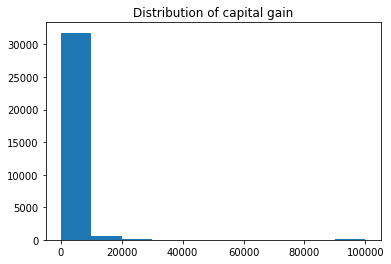

In [33]:
## Plot histogram for capital gain
plot_histogram(income94.capital_gain, 'Distribution of capital gain')

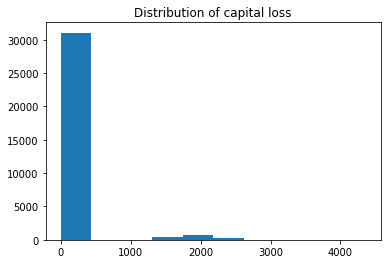

In [34]:
## Plot histogram for capital loss
plot_histogram(income94.capital_loss, 'Distribution of capital loss')

Both these variables are heavily left skewed. We notice that the data is not tidy since capital gain and capital loss represent the same variable capital gain/loss essentially, where a gain is a positive number while a loss is negative. Hence we transform these to a single variable equal to gain - loss (since those countries that have a loss have zero gain and vice-versa).

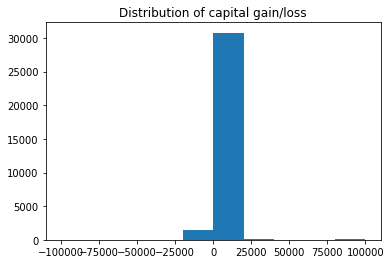

In [37]:
## Create new column 'capital', remove redundant columns, then plot histogram 
## for new column
income94['capital'] = income94.capital_gain - income94.capital_loss
income94 = income94.drop(columns=['capital_gain', 'capital_loss'])
plot_histogram(income94.capital, 'Distribution of capital gain/loss', (-100000, 100000))

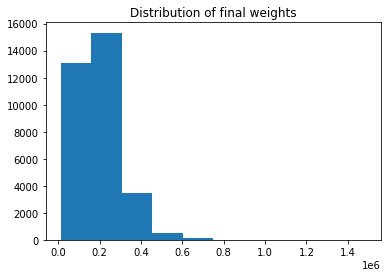

In [12]:
## Plot histogram for fnlwgt
plot_histogram(income94.fnlwgt, "Distribution of final weights")

The variable ```fnlwgt``` is not symmetrically distributed, but is left skewed.

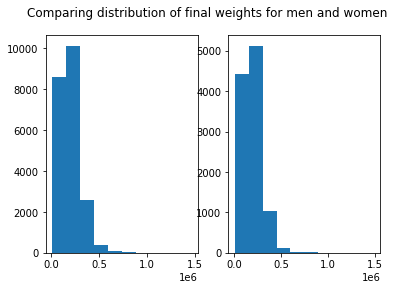

In [13]:
## Plot final weights for men and women side-by-side
fig, (plt1, plt2) = plt.subplots(1, 2)
fig.suptitle('Comparing distribution of final weights for men and women')
plt1.hist(income94[income94.sex == 'Male'].fnlwgt) 
plt2.hist(income94[income94.sex == 'Female'].fnlwgt)
fig.show()

The distribution for ```fnlwgt``` is highly similar for both men and women. It is clear from the frequencies that the number of observations for men is nearly double the number of observations for women. Most people, regardless of sex, have a final weight between 0 and 0.35.

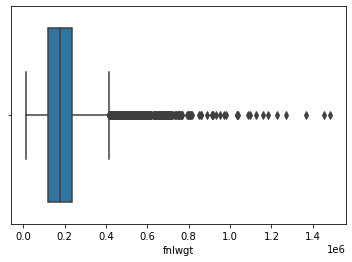

In [14]:
## Plot boxplot for fnlwgt to find outliers
sns.boxplot(x='fnlwgt', data=income94)

In [15]:
def get_outliers(num_var, df):
  '''Get outliers based on whiskers from 
  boxplot.
  Input - num_var: A string representing the v
  variable of interest
  df: The pd df containing the numerical data
  Output: A pd df containing the outlier obs
  (Code from the lab)
  '''
  # Capture 1st and 3rd quartiles
  firstquart = df[num_var].quantile(q=0.25)
  thirdquart = df[num_var].quantile(q=0.75)
  # Generate IQR
  iqr = thirdquart - firstquart
  # Generate Whiskers
  lower_whisker = firstquart - 1.5*iqr
  upper_whisker = thirdquart + 1.5*iqr
  # Gen outlier df
  outliers = df[(df[num_var] > upper_whisker) | (df[num_var] < lower_whisker)]
  print('The variable {} has {} outliers'.format(num_var, len(outliers)))
  return outliers

outliers = get_outliers('fnlwgt', income94)
income94.fnlwgt.loc[outliers.index] = np.nan ## Set outliers to np.nan

The variable fnlwgt has 992 outliers


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


```fnlwgt``` has 992 outliers based on the IQR formula. Since these are so far from the center of the distribution, they may cause inconsistencies in our analyses so we should remove them (set them to ```np.nan```)

                     age  education_num  hours_per_week
age             1.000000       0.036527        0.068756
education_num   0.036527       1.000000        0.148123
hours_per_week  0.068756       0.148123        1.000000


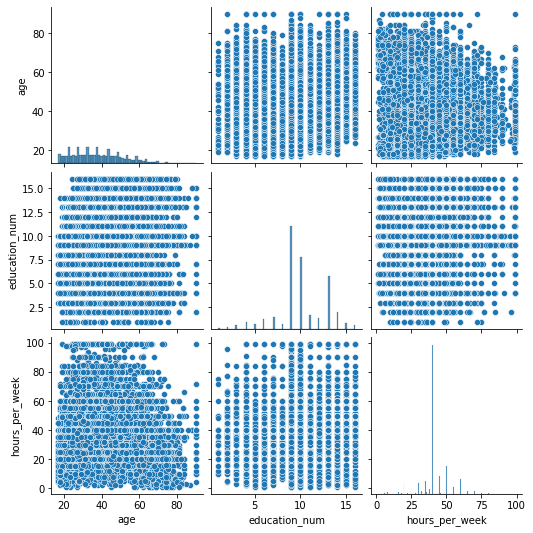

In [16]:
print(income94[['age', 'education_num', 'hours_per_week']].corr()) ## print correlation matrix
sns.pairplot(income94[['age', 'education_num', 'hours_per_week']]) ## plot pairplots for the variables
plt.show()

Looking at the pair plots, we can say that there isn't much correlation between any of the variables since all pairwise plots are null plots.  

```hours_per_week``` and ```education_num``` is the only pair with |correlation|  > 0.1.

In [17]:
stats.pearsonr(income94['education_num'], income94['hours_per_week']) ## Get r value and significance

(0.1481227326229122, 4.2366474790836004e-159)

We perform a t-test under the null hypothesis that the two variables are completely uncorrelated. Since the p-value for the correlation coefficient is of the factor of -159, there is very strong evidence to reject this null hypothesis. Since the correlation coefficient is a small positive number  (0.148) we know that they have a weak positive correlation.

In [18]:
male_income94 = income94[income94['sex'] == 'Male']
female_income94 = income94[income94['sex'] == 'Female']
print(stats.pearsonr(male_income94['education_num'], male_income94['age'])) ## Get r value and significance
print(stats.pearsonr(female_income94['education_num'], female_income94['age'])) ## Get r value and significance

(0.060486409198268254, 4.0229868301718123e-19)
(-0.017899243935447704, 0.06322895030804963)


The correlation for males is very small, and the p-value is significant so we can say that there is enough evidence to say that ```education_num``` is nearly uncorrelated to ```age```.

For females, the p-value is not significant under 5% significance threshold, so we cannot make any inferences about the correlation. 



In [19]:
print("Unweighted Covariance Matrix for education_num vs hours_per_week:")
print(np.cov(income94.education_num, income94.hours_per_week))
print("Weighted Covariance Matrix for education_num vs hours_per_week:")
print(np.cov(income94.education_num, income94.hours_per_week, aweights=np.nan_to_num(income94.fnlwgt)))

Unweighted Covariance Matrix for education_num vs hours_per_week:
[[  6.61888991   4.70533794]
 [  4.70533794 152.45899505]]
Weighted Covariance Matrix for education_num vs hours_per_week:
[[  6.72806198   4.67564304]
 [  4.67564304 147.62659984]]


In [20]:
reg = smf.ols('hours_per_week~sex', income94).fit() ## fit regression model

In [21]:
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1807.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:01:58   Log-Likelihood:            -1.2716e+05
No. Observations:               32561   AIC:                         2.543e+05
Df Residuals:                   32559   BIC:                         2.543e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      36.4104      0.116    314.412      

a. The slope of the regression line is 6.0177. Since the p-value is less than 0.05, we have enough evidence to say that the average ```hours_per_week``` value is 6.0177 higher for males than for females.

In [22]:
reg2 = smf.ols('hours_per_week~sex+education_num', income94).fit() ## fit regression model
print(reg2.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1295.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:01:59   Log-Likelihood:            -1.2680e+05
No. Observations:               32561   AIC:                         2.536e+05
Df Residuals:                   32558   BIC:                         2.536e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        29.4106      0.281    104.556

b. The slope for the regression line is nearly the same. Since the p-value for ```education_num``` is less than 0.05, the slope for it (=0.6975) is significant.

In [23]:
reg3 = smf.ols('hours_per_week~sex+education_num+gross_income_group', income94).fit() ## fit regression model
print(reg3.summary())

                            OLS Regression Results                            
Dep. Variable:         hours_per_week   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     1130.
Date:                Wed, 03 Feb 2021   Prob (F-statistic):               0.00
Time:                        01:01:59   Log-Likelihood:            -1.2643e+05
No. Observations:               32561   AIC:                         2.529e+05
Df Residuals:                   32557   BIC:                         2.529e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

c. The slope for ```sex``` decreases and so does the slope for ```education_num```. The slope for ```gross_income_group``` is 4.5175. All slopes are significant. We can use BIC for model selection, in which case the model with 3 variables is the best since it minimizes BIC. We could have used forward selection with BIC, which is a type of stepwise regression where we add (or cease to add) a variable based on which choice minimizes the value of BIC.